# Adaptive Clustering based Intrusion Detection


## Imports

In [3]:
#!/usr/bin/env python

__author__ = "Alec F."
__license__ = "GPL"
__version__ = "1.0.1"


import os
import sys
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from core.models.network import AdaptiveClustering
from core.utils.misc import extend_dataset
from core.utils import Dataset

import json

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from core.models.RandomForest import RandomForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as prf, accuracy_score

from pprint import pprint

from codecarbon import track_emissions
from datetime import datetime
import time


## Helpers

We use these helpers functions throughout all our experiments for simplify our main code and improve its readability. In all our experiments, our datasets are separated to approximately obtain a 70/30 train-test split from randomly sampled data. We use the pickle library to save our trained model and defined a set of metrics that are commonly used for classification tasks.

In [11]:
def load_dataset(dataset_path):
    global categories
    if not os.path.exists(dataset_path):
        print(f"Dataset not found: {dataset_path}")
        sys.exit(1)

    df = pd.read_csv(dataset_path, index_col=False, sep=",")

    
    # For binary classification, uncomment the following line
    df['Label.'] = np.where(df['Label.'] == 0, "Normal", "Attack")

    
    train_test_split = .3
    msk = np.random.rand(len(df)) < train_test_split
    train_df = df[msk]
    test_df = df[~msk]

    return train_df, test_df, df


def save_model(rf, filename):
    with open(filename, 'wb') as f:
        pkl.dump(rf, f)


def load_model(filename):
    with open(filename, 'rb') as f:
        m = pkl.load(f)
    return m


class metrics(object):

    def __init__(self, tp=None, tn=None, fp=None, fn=None):
        super(metrics, self).__init__()

        self.tp, self.tn, self.fp, self.fn = tp, tn, fp, fn

        self.metrics = {}

    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    def detection_rate(self):
        return self.tp / (self.tp + self.fn)

    def false_alarm_rate(self):
        return self.fp / (self.fp + self.tn)

    def precision(self):
        return self.tp / (self.tp + self.fp)

    def f1(self):
        prec = self.precision()
        rec = self.detection_rate()
        return 0 if (prec + rec) == 0 else 2 * (prec * rec) / (prec + rec)

    def get_metrics(self):
        self.metrics = {"Acc": self.accuracy(), "DR/Recall": self.detection_rate(), "FAR": self.false_alarm_rate(),
                        "PRECISION": self.precision(), "F1 SCORE": self.f1()}
        return self.metrics

## Adaptive Clustering - training function

We train our Adaptive Clustering network by following the exact settings provided in the paper.
However, we also implement an early stop mechanism allowing us to stop the training as soon as we achieve an acceptable loss.

In [12]:
@track_emissions
def train(X, y,j,dic_loss, lr=1e-4):

    dic_loss[f"entrainement_{j}"] = {}

    batch_size = 1024
    print("Adaptive training...")
    model_ = AdaptiveClustering(encoder_dims=[500, 200, 50], n_kernels=len(categories), kernel_size=10)
    model_.train()


    ds = Dataset(X, y)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=8)

    n_epoch = 4
    optimizer = None

    for i in range(n_epoch):
        iteration_losses = []
        
        for x, labels_ in dl:
            model_.zero_grad()
            _ = model_(x, labels_)
            if optimizer is None:
                optimizer = torch.optim.Adam(model_.parameters(), lr=lr)

            loss = model_.loss()
            loss_value = loss.item()

            iteration_losses.append(loss_value)

            loss.backward()
            optimizer.step()
        dic_loss[f"entrainement_{j}"][f"epoch_{i}"] = iteration_losses
        print(f"Iteration {i} | Loss {np.mean(iteration_losses)}")

    model_.eval()
    return model_

## Variables

Here we define some global variables to locate our datasets and point to our results directory.

In [4]:
root_path = './'

dataset_path = root_path + 'datasets/KDD/kddcup_corrige.csv'


results_path = root_path + f'results/'
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [5]:
model_path = results_path + 'trained_model.pkl'
separator = "-"*50

## Dataset
### Loading dataset

We load the preprocessed dataset as a pandas data frame and show the first few rows.

In [15]:
print(separator)
print("Loading dataset...")
if os.path.exists(extended_dataset_path):
    train_df, test_df, df = load_dataset(extended_dataset_path)
    print("Done loading extended dataset")
else:
    train_df, test_df, df = load_dataset(dataset_path)
    print("Done loading dataset")


--------------------------------------------------
Loading dataset...
Done loading dataset


In [16]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label.
0,0,0,0,0,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,Attack
1,0,0,0,0,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,Normal
2,0,0,0,0,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,Normal
3,0,0,0,0,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,Normal
4,0,0,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,Normal


### Preparing the data

We prepare the features to be in the correct format for our Adaptive Clustering network and the Random Forest Classifier.

The labels are separated from the training features and the order of the categories are kept track of in order to use them in the same order when evaluating the model on the testing set.

In [17]:
if os.path.exists(model_path + ".categories"):
    print(separator)
    print("Loading categories...")
    with open(model_path + ".categories", "r") as f:
        categories = json.load(f)
        print(f"categories loaded: {model_path}.categories")
    print("Done loading categories")
else:
    print("Creating categories...")
    categories = list(set(pd.factorize(train_df['Label.'])[1].values))
    print("Done creating categories...")

print("catégories de trafic traitées:",categories)

train_df_ = train_df.drop(['Label.'], axis=1)

X = train_df_.values.tolist()
y = train_df['Label.'].values.tolist()

X = torch.FloatTensor(np.array(X))

for i, l in enumerate(y):
    y[i] = categories.index(l)

y = torch.LongTensor(np.array(y))

cats = df['Label.'].copy()
y_ = df['Label.'].values
df.drop(['Label.'], axis=1, inplace=True)

Creating categories...
Done creating categories...
catégories de trafic traitées: ['Attack', 'Normal']


## Learning

### Training the model

We train our model until we achieve an acceptable loss and export an extended dataset with the cluster centers obtained from the Adaptive Clustering network. This would allow us to not have to retrain our network for every single execution.

In [18]:
dico_temps = {}
if not os.path.exists(model_path):
    global dic_loss
    dic_loss = {}
    print("Training model...")

    debut = time.time()
    date = datetime.now()
    model = train(X, y, 0,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_0"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_1 = train(X, y, 1,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_1"] = [date,durée]

    debut = time.time()
    date = datetime.now()
    model_2 = train(X, y, 2,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_2"] = [date,durée]

    debut = time.time()
    date = datetime.now()
    model_3 = train(X, y, 3,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_3"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_4 = train(X, y, 4,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_4"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_5 = train(X, y, 5,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_5"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_6 = train(X, y, 6,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_6"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_7 = train(X, y, 7,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_7"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_8 = train(X, y, 8,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_8"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_9 = train(X, y, 9,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_9"] = [date,durée]

    # Sauvegarde du dictionnaire_loss dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dic_loss.pkl", 'wb') as file:
        pkl.dump(dic_loss, file)

    # Sauvegarde du dictionnaire_temps dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dico_temps.pkl", 'wb') as file:
        pkl.dump(dico_temps, file)

    print("Done training model")


[codecarbon WARNING @ 16:48:45] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 16:48:45] [setup] RAM Tracking...
[codecarbon INFO @ 16:48:45] [setup] GPU Tracking...
[codecarbon INFO @ 16:48:45] Tracking Nvidia GPU via pynvml


Training model...


[codecarbon INFO @ 16:48:45] [setup] CPU Tracking...
[codecarbon WARNING @ 16:48:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:48:47] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 16:48:47] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 238, in get_gpu_details
    devices_info.append(gpu_device.get_gpu_details())
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\codecarbon\core\gpu.py", line 75, in get_gpu_details
    "power_usage": self._get_power_usage(),
                   ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxou\AppData\Local\Packages\

Adaptive training...


[codecarbon INFO @ 16:49:06] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:49:07] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 0.7496897598602222 W
[codecarbon INFO @ 16:49:07] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:49:07] 0.000132 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:49:21] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:49:22] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.3491247543832268 W
[codecarbon INFO @ 16:49:22] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:49:22] 0.000257 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:49:36] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:49:37] Energy consumed for all GPUs : 0.000021 kWh. Total GPU Power : 2.1969827562749

Iteration 0 | Loss 0.2601704814245608


[codecarbon INFO @ 16:52:36] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:52:37] Energy consumed for all GPUs : 0.000125 kWh. Total GPU Power : 2.2210446009061733 W
[codecarbon INFO @ 16:52:37] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:52:37] 0.001879 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:52:51] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:52:52] Energy consumed for all GPUs : 0.000134 kWh. Total GPU Power : 2.3110554891336514 W
[codecarbon INFO @ 16:52:52] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:52:52] 0.002004 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:53:06] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:53:07] Energy consumed for all GPUs : 0.000143 kWh. Total GPU Power : 2.3377104552131

Iteration 1 | Loss 0.032853102251176505


[codecarbon INFO @ 16:56:21] Energy consumed for RAM : 0.000671 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:56:22] Energy consumed for all GPUs : 0.000255 kWh. Total GPU Power : 2.368134120810904 W
[codecarbon INFO @ 16:56:22] Energy consumed for all CPUs : 0.002824 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:56:22] 0.003750 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:56:36] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:56:37] Energy consumed for all GPUs : 0.000263 kWh. Total GPU Power : 2.1695853753241776 W
[codecarbon INFO @ 16:56:37] Energy consumed for all CPUs : 0.002918 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 16:56:37] 0.003874 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:56:51] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 16:56:52] Energy consumed for all GPUs : 0.000272 kWh. Total GPU Power : 2.19583402478944

Iteration 2 | Loss 0.018249780417959566


[codecarbon INFO @ 17:00:06] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:00:07] Energy consumed for all GPUs : 0.000382 kWh. Total GPU Power : 2.1900563345533897 W
[codecarbon INFO @ 17:00:07] Energy consumed for all CPUs : 0.004231 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:00:07] 0.005618 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:21] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:00:22] Energy consumed for all GPUs : 0.000391 kWh. Total GPU Power : 2.153860592648486 W
[codecarbon INFO @ 17:00:22] Energy consumed for all CPUs : 0.004325 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:00:22] 0.005743 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:36] Energy consumed for RAM : 0.001050 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:00:37] Energy consumed for all GPUs : 0.000399 kWh. Total GPU Power : 2.20238574592056

Iteration 3 | Loss 0.013080818343013887


[codecarbon INFO @ 17:03:46] Energy consumed for all GPUs : 0.000513 kWh. Total GPU Power : 4.375443627116292 W
[codecarbon INFO @ 17:03:46] Energy consumed for all CPUs : 0.005597 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:03:46] 0.007438 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:03:46] Done!

[codecarbon WARNING @ 17:03:46] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 17:03:46] [setup] RAM Tracking...
[codecarbon INFO @ 17:03:46] [setup] GPU Tracking...
[codecarbon INFO @ 17:03:46] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:03:46] [setup] CPU Tracking...
[codecarbon WARNING @ 17:03:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:03:47] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 17:03:48] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\Python

Adaptive training...


[codecarbon INFO @ 17:04:07] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:04:08] Energy consumed for all GPUs : 0.000005 kWh. Total GPU Power : 1.273558165095072 W
[codecarbon INFO @ 17:04:08] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:04:08] 0.000134 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:04:22] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:04:23] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 2.231848193288499 W
[codecarbon INFO @ 17:04:23] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:04:23] 0.000259 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:04:37] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:04:38] Energy consumed for all GPUs : 0.000023 kWh. Total GPU Power : 2.263017667624543

Iteration 0 | Loss 0.5055631273439086


[codecarbon INFO @ 17:07:37] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:07:38] Energy consumed for all GPUs : 0.000128 kWh. Total GPU Power : 2.1933744142366645 W
[codecarbon INFO @ 17:07:38] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:07:38] 0.001882 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:07:52] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:07:53] Energy consumed for all GPUs : 0.000137 kWh. Total GPU Power : 2.2991988911615397 W
[codecarbon INFO @ 17:07:53] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:07:53] 0.002007 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:08:07] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:08:08] Energy consumed for all GPUs : 0.000145 kWh. Total GPU Power : 2.2302026790475

Iteration 1 | Loss 0.018600576880684998


[codecarbon INFO @ 17:11:22] Energy consumed for RAM : 0.000671 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:11:23] Energy consumed for all GPUs : 0.000264 kWh. Total GPU Power : 2.2752344442027574 W
[codecarbon INFO @ 17:11:23] Energy consumed for all CPUs : 0.002824 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:11:23] 0.003759 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:11:37] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:11:38] Energy consumed for all GPUs : 0.000273 kWh. Total GPU Power : 2.2133701314405485 W
[codecarbon INFO @ 17:11:38] Energy consumed for all CPUs : 0.002918 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:11:38] 0.003884 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:11:52] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:11:53] Energy consumed for all GPUs : 0.000282 kWh. Total GPU Power : 2.2333979479116

Iteration 2 | Loss 0.013583554035865943


[codecarbon INFO @ 17:15:07] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:15:08] Energy consumed for all GPUs : 0.000395 kWh. Total GPU Power : 2.1940804839606365 W
[codecarbon INFO @ 17:15:08] Energy consumed for all CPUs : 0.004231 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:15:08] 0.005630 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:15:22] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:15:23] Energy consumed for all GPUs : 0.000403 kWh. Total GPU Power : 2.231513549387574 W
[codecarbon INFO @ 17:15:23] Energy consumed for all CPUs : 0.004325 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:15:23] 0.005755 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:15:37] Energy consumed for RAM : 0.001050 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:15:38] Energy consumed for all GPUs : 0.000412 kWh. Total GPU Power : 2.17043672619994

Iteration 3 | Loss 0.009547003672226698


[codecarbon INFO @ 17:18:53] Energy consumed for all GPUs : 0.000540 kWh. Total GPU Power : 4.321406255612004 W
[codecarbon INFO @ 17:18:53] Energy consumed for all GPUs : 0.000540 kWh. Total GPU Power : 0.0 W
[codecarbon INFO @ 17:18:53] Energy consumed for all CPUs : 0.005634 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:18:53] Energy consumed for all CPUs : 0.005723 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:18:53] 0.007625 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:18:53] 0.007625 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:18:53] Done!

[codecarbon WARNING @ 17:18:53] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 17:18:53] [setup] RAM Tracking...
[codecarbon INFO @ 17:18:53] [setup] GPU Tracking...
[codecarbon INFO @ 17:18:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:18:53] [setup] CPU Tracking...
[codecarbon WARNING @ 17:18:53] No CPU tracking mode found. Falling back on CP

Adaptive training...


[codecarbon INFO @ 17:19:14] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:19:15] Energy consumed for all GPUs : 0.000005 kWh. Total GPU Power : 1.200148703634452 W
[codecarbon INFO @ 17:19:15] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:19:15] 0.000134 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:29] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:19:30] Energy consumed for all GPUs : 0.000017 kWh. Total GPU Power : 3.1759289104447075 W
[codecarbon INFO @ 17:19:30] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:19:30] 0.000262 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:44] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:19:45] Energy consumed for all GPUs : 0.000026 kWh. Total GPU Power : 2.19488893080364

Iteration 0 | Loss 0.4367812768307133


[codecarbon INFO @ 17:22:59] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:23:00] Energy consumed for all GPUs : 0.000137 kWh. Total GPU Power : 2.1928997599793765 W
[codecarbon INFO @ 17:23:00] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:23:00] 0.002007 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:14] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:23:15] Energy consumed for all GPUs : 0.000146 kWh. Total GPU Power : 2.1697739980122193 W
[codecarbon INFO @ 17:23:15] Energy consumed for all CPUs : 0.001605 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:23:15] 0.002131 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:23:29] Energy consumed for RAM : 0.000404 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:23:30] Energy consumed for all GPUs : 0.000154 kWh. Total GPU Power : 2.2344564998956

Iteration 1 | Loss 0.01953239254066513


[codecarbon INFO @ 17:26:44] Energy consumed for RAM : 0.000696 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:26:45] Energy consumed for all GPUs : 0.000328 kWh. Total GPU Power : 2.4282877585780533 W
[codecarbon INFO @ 17:26:45] Energy consumed for all CPUs : 0.002917 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:26:45] 0.003941 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:59] Energy consumed for RAM : 0.000718 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:27:00] Energy consumed for all GPUs : 0.000337 kWh. Total GPU Power : 2.2120517024167055 W
[codecarbon INFO @ 17:27:00] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:27:00] 0.004066 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:27:14] Energy consumed for RAM : 0.000740 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:27:15] Energy consumed for all GPUs : 0.000345 kWh. Total GPU Power : 2.2271150323906

Iteration 2 | Loss 0.013515737747272844


[codecarbon INFO @ 17:30:29] Energy consumed for RAM : 0.001030 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:30:30] Energy consumed for all GPUs : 0.000459 kWh. Total GPU Power : 2.243444083524825 W
[codecarbon INFO @ 17:30:30] Energy consumed for all CPUs : 0.004325 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:30:30] 0.005814 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:44] Energy consumed for RAM : 0.001052 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:30:45] Energy consumed for all GPUs : 0.000467 kWh. Total GPU Power : 2.2016534766441667 W
[codecarbon INFO @ 17:30:45] Energy consumed for all CPUs : 0.004419 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:30:45] 0.005938 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:30:59] Energy consumed for RAM : 0.001075 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:31:00] Energy consumed for all GPUs : 0.000476 kWh. Total GPU Power : 2.25387845562576

Iteration 3 | Loss 0.01067983429879923


[codecarbon INFO @ 17:34:01] Energy consumed for all GPUs : 0.000589 kWh. Total GPU Power : 59.346711741872014 W
[codecarbon INFO @ 17:34:01] Energy consumed for all CPUs : 0.005645 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:34:01] 0.007577 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:01] Done!

[codecarbon WARNING @ 17:34:01] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 17:34:01] [setup] RAM Tracking...
[codecarbon INFO @ 17:34:01] [setup] GPU Tracking...
[codecarbon INFO @ 17:34:01] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:34:01] [setup] CPU Tracking...
[codecarbon WARNING @ 17:34:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:34:03] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 17:34:03] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\Pytho

Adaptive training...


[codecarbon INFO @ 17:34:22] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:34:23] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 0.722306315666431 W
[codecarbon INFO @ 17:34:23] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:34:23] 0.000132 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:37] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:34:38] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.1990714763528993 W
[codecarbon INFO @ 17:34:38] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:34:38] 0.000257 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:34:52] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:34:53] Energy consumed for all GPUs : 0.000020 kWh. Total GPU Power : 2.22117965327004

Iteration 0 | Loss 0.1466389991872241


[codecarbon INFO @ 17:37:52] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:37:54] Energy consumed for all GPUs : 0.000124 kWh. Total GPU Power : 2.2051288832062728 W
[codecarbon INFO @ 17:37:54] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:37:54] 0.001878 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:38:07] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:38:09] Energy consumed for all GPUs : 0.000133 kWh. Total GPU Power : 2.239048657938658 W
[codecarbon INFO @ 17:38:09] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:38:09] 0.002002 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:38:22] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:38:24] Energy consumed for all GPUs : 0.000141 kWh. Total GPU Power : 2.21723671222390

Iteration 1 | Loss 0.012441404039558401


[codecarbon INFO @ 17:41:37] Energy consumed for RAM : 0.000671 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:41:39] Energy consumed for all GPUs : 0.000256 kWh. Total GPU Power : 2.5383775980629286 W
[codecarbon INFO @ 17:41:39] Energy consumed for all CPUs : 0.002824 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:41:39] 0.003751 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:41:52] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:41:54] Energy consumed for all GPUs : 0.000265 kWh. Total GPU Power : 2.316034078250857 W
[codecarbon INFO @ 17:41:54] Energy consumed for all CPUs : 0.002918 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:41:54] 0.003876 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:42:08] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:42:09] Energy consumed for all GPUs : 0.000274 kWh. Total GPU Power : 2.33928543732263

Iteration 2 | Loss 0.00817113978305733


[codecarbon INFO @ 17:45:23] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:45:24] Energy consumed for all GPUs : 0.000387 kWh. Total GPU Power : 2.2413994413260623 W
[codecarbon INFO @ 17:45:24] Energy consumed for all CPUs : 0.004231 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:45:24] 0.005623 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:38] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:45:39] Energy consumed for all GPUs : 0.000397 kWh. Total GPU Power : 2.6147710269831927 W
[codecarbon INFO @ 17:45:39] Energy consumed for all CPUs : 0.004325 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:45:39] 0.005749 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:53] Energy consumed for RAM : 0.001050 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:45:54] Energy consumed for all GPUs : 0.000406 kWh. Total GPU Power : 2.3287994611196

Iteration 3 | Loss 0.005925646341039538


[codecarbon INFO @ 17:48:54] Energy consumed for all GPUs : 0.000512 kWh. Total GPU Power : 2.1008528762627106 W
[codecarbon INFO @ 17:48:54] Energy consumed for all CPUs : 0.005544 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:48:54] 0.007396 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:48:54] Energy consumed for all GPUs : 0.000512 kWh. Total GPU Power : 0.0 W
[codecarbon INFO @ 17:48:54] Energy consumed for all CPUs : 0.005544 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:48:54] 0.007396 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:48:54] Done!

[codecarbon WARNING @ 17:48:54] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 17:48:54] [setup] RAM Tracking...
[codecarbon INFO @ 17:48:54] [setup] GPU Tracking...
[codecarbon INFO @ 17:48:54] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:48:54] [setup] CPU Tracking...
[codecarbon WARNING @ 17:48:54] No CPU tracking mode found. Falling back on C

Adaptive training...


[codecarbon INFO @ 17:49:15] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:49:16] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 0.7285479216996076 W
[codecarbon INFO @ 17:49:16] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:49:16] 0.000132 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:30] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:49:31] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.2156156963546487 W
[codecarbon INFO @ 17:49:31] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:49:31] 0.000257 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:49:45] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:49:46] Energy consumed for all GPUs : 0.000020 kWh. Total GPU Power : 2.2108031299551

Iteration 0 | Loss 0.4039394106913078


[codecarbon INFO @ 17:52:45] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:52:46] Energy consumed for all GPUs : 0.000124 kWh. Total GPU Power : 2.189948045461712 W
[codecarbon INFO @ 17:52:46] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:52:46] 0.001878 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:00] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:53:01] Energy consumed for all GPUs : 0.000133 kWh. Total GPU Power : 2.2293302183184878 W
[codecarbon INFO @ 17:53:01] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:53:01] 0.002002 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:53:15] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:53:16] Energy consumed for all GPUs : 0.000142 kWh. Total GPU Power : 2.30029266187764

Iteration 1 | Loss 0.07698417575199748


[codecarbon INFO @ 17:56:30] Energy consumed for RAM : 0.000671 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:56:31] Energy consumed for all GPUs : 0.000255 kWh. Total GPU Power : 2.2592022813029313 W
[codecarbon INFO @ 17:56:31] Energy consumed for all CPUs : 0.002823 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:56:31] 0.003749 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:56:45] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:56:46] Energy consumed for all GPUs : 0.000270 kWh. Total GPU Power : 3.9387135921479945 W
[codecarbon INFO @ 17:56:46] Energy consumed for all CPUs : 0.002917 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 17:56:46] 0.003880 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:57:00] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 17:57:01] Energy consumed for all GPUs : 0.000274 kWh. Total GPU Power : 1.1006521052558

Iteration 2 | Loss 0.029523726343890666


[codecarbon INFO @ 18:00:15] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:00:16] Energy consumed for all GPUs : 0.000388 kWh. Total GPU Power : 2.219699882257417 W
[codecarbon INFO @ 18:00:16] Energy consumed for all CPUs : 0.004230 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:00:16] 0.005622 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:00:30] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:00:31] Energy consumed for all GPUs : 0.000397 kWh. Total GPU Power : 2.366497364365378 W
[codecarbon INFO @ 18:00:31] Energy consumed for all CPUs : 0.004324 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:00:31] 0.005747 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:00:45] Energy consumed for RAM : 0.001049 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:00:46] Energy consumed for all GPUs : 0.000405 kWh. Total GPU Power : 2.176662772222612

Iteration 3 | Loss 0.016240969067601575


[codecarbon INFO @ 18:03:51] Energy consumed for all GPUs : 0.000518 kWh. Total GPU Power : 6.788682442581958 W
[codecarbon INFO @ 18:03:51] Energy consumed for all CPUs : 0.005575 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:03:51] 0.007416 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:03:51] Done!

[codecarbon WARNING @ 18:03:51] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 18:03:51] [setup] RAM Tracking...
[codecarbon INFO @ 18:03:51] [setup] GPU Tracking...
[codecarbon INFO @ 18:03:51] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:03:51] [setup] CPU Tracking...
[codecarbon WARNING @ 18:03:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:03:53] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 18:03:53] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\Python

Adaptive training...


[codecarbon INFO @ 18:04:12] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:04:13] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 0.7102602376522278 W
[codecarbon INFO @ 18:04:13] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:04:13] 0.000132 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:27] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:04:28] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.3266431614915564 W
[codecarbon INFO @ 18:04:28] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:04:28] 0.000257 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:42] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:04:43] Energy consumed for all GPUs : 0.000021 kWh. Total GPU Power : 2.3939427767558

Iteration 0 | Loss 0.4176843253867104


[codecarbon INFO @ 18:07:42] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:07:44] Energy consumed for all GPUs : 0.000126 kWh. Total GPU Power : 2.210517545993925 W
[codecarbon INFO @ 18:07:44] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:07:44] 0.001880 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:07:57] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:07:59] Energy consumed for all GPUs : 0.000135 kWh. Total GPU Power : 2.3203722477722732 W
[codecarbon INFO @ 18:07:59] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:07:59] 0.002005 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:08:12] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:08:14] Energy consumed for all GPUs : 0.000143 kWh. Total GPU Power : 2.21514216197498

Iteration 1 | Loss 0.04960618004420757


[codecarbon INFO @ 18:11:27] Energy consumed for RAM : 0.000671 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:11:29] Energy consumed for all GPUs : 0.000259 kWh. Total GPU Power : 2.4128540111981733 W
[codecarbon INFO @ 18:11:29] Energy consumed for all CPUs : 0.002824 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:11:29] 0.003754 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:11:43] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:11:44] Energy consumed for all GPUs : 0.000268 kWh. Total GPU Power : 2.2314520612297035 W
[codecarbon INFO @ 18:11:44] Energy consumed for all CPUs : 0.002918 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:11:44] 0.003879 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:11:58] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:11:59] Energy consumed for all GPUs : 0.000277 kWh. Total GPU Power : 2.2646906873643

Iteration 2 | Loss 0.021759395323198257


[codecarbon INFO @ 18:15:13] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:15:14] Energy consumed for all GPUs : 0.000389 kWh. Total GPU Power : 2.32280568409723 W
[codecarbon INFO @ 18:15:14] Energy consumed for all CPUs : 0.004231 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:15:14] 0.005625 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:28] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:15:29] Energy consumed for all GPUs : 0.000398 kWh. Total GPU Power : 2.2198893789381633 W
[codecarbon INFO @ 18:15:29] Energy consumed for all CPUs : 0.004325 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:15:29] 0.005750 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:15:43] Energy consumed for RAM : 0.001049 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:15:44] Energy consumed for all GPUs : 0.000407 kWh. Total GPU Power : 2.217826791214714

Iteration 3 | Loss 0.01539966068457563


[codecarbon INFO @ 18:18:48] Energy consumed for all GPUs : 0.000523 kWh. Total GPU Power : 8.216816006133477 W
[codecarbon INFO @ 18:18:48] Energy consumed for all CPUs : 0.005571 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:18:48] 0.007417 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:48] Done!

[codecarbon WARNING @ 18:18:48] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 18:18:48] [setup] RAM Tracking...
[codecarbon INFO @ 18:18:48] [setup] GPU Tracking...
[codecarbon INFO @ 18:18:48] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:18:48] [setup] CPU Tracking...
[codecarbon WARNING @ 18:18:48] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:18:50] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 18:18:50] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\Python

Adaptive training...


[codecarbon INFO @ 18:19:09] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:19:10] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 0.7269287294901496 W
[codecarbon INFO @ 18:19:10] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:19:10] 0.000132 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:19:24] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:19:25] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.2513358589885786 W
[codecarbon INFO @ 18:19:25] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:19:25] 0.000257 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:19:39] Energy consumed for RAM : 0.000070 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:19:40] Energy consumed for all GPUs : 0.000020 kWh. Total GPU Power : 2.1781115119438

Iteration 0 | Loss 0.2457532495082535


[codecarbon INFO @ 18:22:39] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:22:40] Energy consumed for all GPUs : 0.000125 kWh. Total GPU Power : 2.2606483311862715 W
[codecarbon INFO @ 18:22:40] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:22:40] 0.001879 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:22:54] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:22:55] Energy consumed for all GPUs : 0.000134 kWh. Total GPU Power : 2.5369781227371395 W
[codecarbon INFO @ 18:22:55] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:22:55] 0.002005 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:23:09] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:23:10] Energy consumed for all GPUs : 0.000144 kWh. Total GPU Power : 2.4908462695414

Iteration 1 | Loss 0.011453613044397678


[codecarbon INFO @ 18:26:25] Energy consumed for all GPUs : 0.000258 kWh. Total GPU Power : 2.2452802860324685 W
[codecarbon INFO @ 18:26:25] Energy consumed for all CPUs : 0.002824 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:26:25] 0.003753 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:39] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:26:40] Energy consumed for all GPUs : 0.000268 kWh. Total GPU Power : 2.494805210835458 W
[codecarbon INFO @ 18:26:40] Energy consumed for all CPUs : 0.002918 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:26:40] 0.003879 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:26:54] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:26:55] Energy consumed for all GPUs : 0.000277 kWh. Total GPU Power : 2.3193025307415085 W
[codecarbon INFO @ 18:26:55] Energy consumed for all CPUs : 0.003012 kWh. Total CPU Power : 22.5

Iteration 2 | Loss 0.009147855070181914


[codecarbon INFO @ 18:30:09] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:30:10] Energy consumed for all GPUs : 0.000390 kWh. Total GPU Power : 2.1949001650301736 W
[codecarbon INFO @ 18:30:10] Energy consumed for all CPUs : 0.004231 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:30:10] 0.005626 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:24] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:30:25] Energy consumed for all GPUs : 0.000399 kWh. Total GPU Power : 2.2655921903318683 W
[codecarbon INFO @ 18:30:25] Energy consumed for all CPUs : 0.004324 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:30:25] 0.005750 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:30:39] Energy consumed for RAM : 0.001049 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:30:40] Energy consumed for all GPUs : 0.000408 kWh. Total GPU Power : 2.2609794275181

Iteration 3 | Loss 0.008020999072045659


[codecarbon INFO @ 18:33:55] Energy consumed for all GPUs : 0.000521 kWh. Total GPU Power : 2.345280706955378 W
[codecarbon INFO @ 18:33:55] Energy consumed for all CPUs : 0.005632 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:33:55] 0.007490 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:33:55] Done!

[codecarbon WARNING @ 18:33:55] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 18:33:55] [setup] RAM Tracking...
[codecarbon INFO @ 18:33:55] [setup] GPU Tracking...
[codecarbon INFO @ 18:33:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:33:55] [setup] CPU Tracking...
[codecarbon WARNING @ 18:33:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:33:56] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 18:33:57] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\Python

Adaptive training...


[codecarbon INFO @ 18:34:16] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:34:17] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 0.7271988002024824 W
[codecarbon INFO @ 18:34:17] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:34:17] 0.000132 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:31] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:34:32] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.2228935133078975 W
[codecarbon INFO @ 18:34:32] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:34:32] 0.000257 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:34:46] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:34:47] Energy consumed for all GPUs : 0.000020 kWh. Total GPU Power : 2.2298811673002

Iteration 0 | Loss 0.20509349610779726


[codecarbon INFO @ 18:37:46] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:37:47] Energy consumed for all GPUs : 0.000126 kWh. Total GPU Power : 2.313727400952887 W
[codecarbon INFO @ 18:37:47] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:37:47] 0.001880 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:01] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:38:02] Energy consumed for all GPUs : 0.000135 kWh. Total GPU Power : 2.217302581033947 W
[codecarbon INFO @ 18:38:02] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:38:02] 0.002005 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:16] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:38:17] Energy consumed for all GPUs : 0.000143 kWh. Total GPU Power : 2.258727163120663

Iteration 1 | Loss 0.013821194397105932


[codecarbon INFO @ 18:41:31] Energy consumed for RAM : 0.000671 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:41:32] Energy consumed for all GPUs : 0.000257 kWh. Total GPU Power : 2.2209578590332457 W
[codecarbon INFO @ 18:41:32] Energy consumed for all CPUs : 0.002824 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:41:32] 0.003751 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:41:46] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:41:47] Energy consumed for all GPUs : 0.000265 kWh. Total GPU Power : 2.24123302049307 W
[codecarbon INFO @ 18:41:47] Energy consumed for all CPUs : 0.002918 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:41:47] 0.003876 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:42:01] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:42:02] Energy consumed for all GPUs : 0.000274 kWh. Total GPU Power : 2.198148099041326

Iteration 2 | Loss 0.010718372006593195


[codecarbon INFO @ 18:45:16] Energy consumed for RAM : 0.001005 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:45:17] Energy consumed for all GPUs : 0.000391 kWh. Total GPU Power : 2.414786973355683 W
[codecarbon INFO @ 18:45:17] Energy consumed for all CPUs : 0.004231 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:45:17] 0.005626 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:45:31] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:45:32] Energy consumed for all GPUs : 0.000400 kWh. Total GPU Power : 2.413299642427499 W
[codecarbon INFO @ 18:45:32] Energy consumed for all CPUs : 0.004325 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:45:32] 0.005752 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:45:46] Energy consumed for RAM : 0.001049 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:45:47] Energy consumed for all GPUs : 0.000409 kWh. Total GPU Power : 2.25330781551364 

Iteration 3 | Loss 0.008799020750414058


[codecarbon INFO @ 18:48:57] Energy consumed for all GPUs : 0.000524 kWh. Total GPU Power : 3.5851044474280562 W
[codecarbon INFO @ 18:48:57] Energy consumed for all CPUs : 0.005605 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:48:57] 0.007460 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:48:57] Done!

[codecarbon WARNING @ 18:48:57] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 18:48:57] [setup] RAM Tracking...
[codecarbon INFO @ 18:48:57] [setup] GPU Tracking...
[codecarbon INFO @ 18:48:57] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:48:57] [setup] CPU Tracking...
[codecarbon WARNING @ 18:48:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:48:58] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 18:48:59] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\Pytho

Adaptive training...


[codecarbon INFO @ 18:49:18] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:49:19] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 0.7111166008115869 W
[codecarbon INFO @ 18:49:19] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:49:19] 0.000132 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:33] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:49:34] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.250252460603893 W
[codecarbon INFO @ 18:49:34] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:49:34] 0.000257 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:48] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:49:49] Energy consumed for all GPUs : 0.000021 kWh. Total GPU Power : 2.44027287720592

Iteration 0 | Loss 0.24769791467815722


[codecarbon INFO @ 18:52:48] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:52:49] Energy consumed for all GPUs : 0.000132 kWh. Total GPU Power : 3.730853978728843 W
[codecarbon INFO @ 18:52:49] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:52:49] 0.001886 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:03] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:53:04] Energy consumed for all GPUs : 0.000136 kWh. Total GPU Power : 1.1660085509603209 W
[codecarbon INFO @ 18:53:04] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:53:04] 0.002006 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:18] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:53:19] Energy consumed for all GPUs : 0.000146 kWh. Total GPU Power : 2.36783732792796

Iteration 1 | Loss 0.016157478838315892


[codecarbon INFO @ 18:56:33] Energy consumed for RAM : 0.000671 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:56:34] Energy consumed for all GPUs : 0.000259 kWh. Total GPU Power : 2.3948982534146492 W
[codecarbon INFO @ 18:56:34] Energy consumed for all CPUs : 0.002824 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:56:34] 0.003754 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:56:48] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:56:49] Energy consumed for all GPUs : 0.000269 kWh. Total GPU Power : 2.643495769163864 W
[codecarbon INFO @ 18:56:49] Energy consumed for all CPUs : 0.002918 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 18:56:49] 0.003880 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:03] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 18:57:04] Energy consumed for all GPUs : 0.000278 kWh. Total GPU Power : 2.25293507254460

Iteration 2 | Loss 0.008899091174151531


[codecarbon INFO @ 19:00:19] Energy consumed for all GPUs : 0.000393 kWh. Total GPU Power : 2.322976384303034 W
[codecarbon INFO @ 19:00:19] Energy consumed for all CPUs : 0.004231 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:00:19] 0.005629 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:33] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:00:34] Energy consumed for all GPUs : 0.000402 kWh. Total GPU Power : 2.362508575053044 W
[codecarbon INFO @ 19:00:34] Energy consumed for all CPUs : 0.004325 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:00:34] 0.005754 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:48] Energy consumed for RAM : 0.001049 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:00:49] Energy consumed for all GPUs : 0.000411 kWh. Total GPU Power : 2.258091786053846 W
[codecarbon INFO @ 19:00:49] Energy consumed for all CPUs : 0.004419 kWh. Total CPU Power : 22.5 W

Iteration 3 | Loss 0.0074403070200453215


[codecarbon INFO @ 19:04:04] Energy consumed for all GPUs : 0.000525 kWh. Total GPU Power : 2.3711370095344306 W
[codecarbon INFO @ 19:04:04] Energy consumed for all CPUs : 0.005633 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:04:04] 0.007495 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:04] Done!

[codecarbon WARNING @ 19:04:04] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 19:04:04] [setup] RAM Tracking...
[codecarbon INFO @ 19:04:04] [setup] GPU Tracking...
[codecarbon INFO @ 19:04:04] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:04:04] [setup] CPU Tracking...
[codecarbon WARNING @ 19:04:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 19:04:05] CPU Model on constant consumption mode: AMD Ryzen 9 5900HX with Radeon Graphics
[codecarbon WARNING @ 19:04:06] Failed to retrieve gpu information
Traceback (most recent call last):
  File "C:\Users\maxou\AppData\Local\Packages\Pytho

Adaptive training...


[codecarbon INFO @ 19:04:25] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:04:26] Energy consumed for all GPUs : 0.000003 kWh. Total GPU Power : 0.7272071693434722 W
[codecarbon INFO @ 19:04:26] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:04:26] 0.000132 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:40] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:04:41] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 2.227811148799647 W
[codecarbon INFO @ 19:04:41] Energy consumed for all CPUs : 0.000198 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:04:41] 0.000257 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:55] Energy consumed for RAM : 0.000069 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:04:56] Energy consumed for all GPUs : 0.000020 kWh. Total GPU Power : 2.26041636373727

Iteration 0 | Loss 0.19832175144728553


[codecarbon INFO @ 19:07:55] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:07:56] Energy consumed for all GPUs : 0.000126 kWh. Total GPU Power : 2.355558089795015 W
[codecarbon INFO @ 19:07:56] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:07:56] 0.001880 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:10] Energy consumed for RAM : 0.000359 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:08:11] Energy consumed for all GPUs : 0.000138 kWh. Total GPU Power : 3.200118595471878 W
[codecarbon INFO @ 19:08:11] Energy consumed for all CPUs : 0.001511 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:08:11] 0.002008 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:25] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:08:26] Energy consumed for all GPUs : 0.000147 kWh. Total GPU Power : 2.260650312485992

Iteration 1 | Loss 0.017208622300914363


[codecarbon INFO @ 19:11:41] Energy consumed for all GPUs : 0.000262 kWh. Total GPU Power : 2.2586074899069217 W
[codecarbon INFO @ 19:11:41] Energy consumed for all CPUs : 0.002824 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:11:41] 0.003757 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:55] Energy consumed for RAM : 0.000693 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:11:56] Energy consumed for all GPUs : 0.000271 kWh. Total GPU Power : 2.301143452915449 W
[codecarbon INFO @ 19:11:56] Energy consumed for all CPUs : 0.002918 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:11:56] 0.003882 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:12:10] Energy consumed for RAM : 0.000715 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:12:11] Energy consumed for all GPUs : 0.000279 kWh. Total GPU Power : 2.1906114655986677 W
[codecarbon INFO @ 19:12:11] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 22.5

Iteration 2 | Loss 0.014420230652380432


[codecarbon INFO @ 19:15:40] Energy consumed for RAM : 0.001027 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:15:41] Energy consumed for all GPUs : 0.000404 kWh. Total GPU Power : 2.354754755097324 W
[codecarbon INFO @ 19:15:41] Energy consumed for all CPUs : 0.004324 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:15:41] 0.005756 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:55] Energy consumed for RAM : 0.001049 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:15:56] Energy consumed for all GPUs : 0.000413 kWh. Total GPU Power : 2.274908527883366 W
[codecarbon INFO @ 19:15:56] Energy consumed for all CPUs : 0.004418 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:15:56] 0.005880 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:10] Energy consumed for RAM : 0.001072 kWh. RAM Power : 5.783294677734375 W
[codecarbon INFO @ 19:16:11] Energy consumed for all GPUs : 0.000421 kWh. Total GPU Power : 2.210314081168125

Iteration 3 | Loss 0.011830274744963268


[codecarbon INFO @ 19:19:14] Energy consumed for all GPUs : 0.000534 kWh. Total GPU Power : 12.1785000951391 W
[codecarbon INFO @ 19:19:14] Energy consumed for all CPUs : 0.005656 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 19:19:14] 0.007533 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:14] Done!



Done training model


After obtaining the extended dataset, we train our final classifier and evaluate our Intrusion Detection System.

In [19]:
print(dico_temps)
if not os.path.exists(model_path):
    print("Training Random Forest...")
    model.classifier = RandomForest(n_estimators=200)
    model.classifier.fit(X, y)
    print("Done training Random Forest")

    print("Saving model...")
    save_model(model, model_path)
    with open(model_path+".categories", "w") as f:
        json.dump(categories, f)
        print(f"Categories saved: {model_path}.categories")
    print("Done saving model")

{'entrainement_0': [datetime.datetime(2024, 5, 11, 16, 48, 45, 20520), 901.430543422699], 'entrainement_1': [datetime.datetime(2024, 5, 11, 17, 3, 46, 451063), 906.8524699211121], 'entrainement_2': [datetime.datetime(2024, 5, 11, 17, 18, 53, 303533), 908.5964510440826], 'entrainement_3': [datetime.datetime(2024, 5, 11, 17, 34, 1, 899984), 892.4635858535767], 'entrainement_4': [datetime.datetime(2024, 5, 11, 17, 48, 54, 363570), 897.519008398056], 'entrainement_5': [datetime.datetime(2024, 5, 11, 18, 3, 51, 882579), 896.7454915046692], 'entrainement_6': [datetime.datetime(2024, 5, 11, 18, 18, 48, 628070), 906.5402235984802], 'entrainement_7': [datetime.datetime(2024, 5, 11, 18, 33, 55, 168294), 902.2916986942291], 'entrainement_8': [datetime.datetime(2024, 5, 11, 18, 48, 57, 459992), 906.7756707668304], 'entrainement_9': [datetime.datetime(2024, 5, 11, 19, 4, 4, 235663), 910.4414660930634]}
Training Random Forest...
Done training Random Forest
Saving model...
Categories saved: ./results

In [20]:
if os.path.exists(model_path):
    print("Loading model...")
    model = load_model(model_path)
    print("Done loading model")

Loading model...
Done loading model


### Data distributions 

Here, we print our data distributions per traffic category to verify that we have all categories of our dataset in the test set.

In [21]:
print(f"Total data distribution: {len(test_df) + len(train_df)}")
total = {}
total['total'] = len(test_df) + len(train_df)
for cat in categories:
    total[cat] = len(test_df[test_df['Label.'] == cat]) \
                   + len(train_df[train_df['Label.'] == cat])
    print(f"\t{cat}: {total[cat]}")

print(f"Training data distribution: {len(train_df)} / {len(train_df) * 100 / total['total']}%")
for cat in categories:
    c = len(train_df[train_df['Label.'] == cat])
    print(f"\t{cat}: {c} / {c*100 / total[cat]}%")
    
print(f"Testing data distribution: {len(test_df)} / {len(test_df) * 100 / total['total']}%")
for cat in categories:
    c = len(test_df[test_df['Label.'] == cat])
    print(f"\t{cat}: {c} / {c * 100 / total[cat]}%")



Total data distribution: 4898431
	Attack: 3925651
	Normal: 972780
Training data distribution: 1469481 / 29.99901396998345%
	Attack: 1177705 / 30.000247092775187%
	Normal: 291776 / 29.99403770636732%
Testing data distribution: 3428950 / 70.00098603001655%
	Attack: 2747946 / 69.99975290722482%
	Normal: 681004 / 70.00596229363268%


### Testing the model

To evaluate our model on the unseen set, we remove the labels and run our trained model on the remaining features.

In [22]:
df = test_df.drop(['Label.'], axis=1)
x = df.values.tolist()

y_hat = model.classifier.predict(x)
preds = []

for i in y_hat:
    preds.append(categories[i])

### Confusion matrix

We compute the confusion matrix to observe how well our model works on every single category in our test set.

In [23]:
print("Creating confusion matrix...")

for i, category in enumerate(categories):
    test_df['Label.'].replace(to_replace=category, value=i, inplace=True)
y_actual_ = test_df['Label.'].values.tolist()
y_actual = []
for i in y_actual_:
    y_actual.append(categories[i])

print(f"Uniques actual: {list(set(y_actual))}")
print(f"Uniques preds: {list(set(preds))}")

y_actu = pd.Series(y_actual, name='Actual')
y_pred = pd.Series(preds, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4) * 100

df_confusion.to_csv(results_path + 'rf_confusion_matrix.csv')
print(f"Confusion matrix created and saved: {results_path}rf_confusion_matrix.csv")

Creating confusion matrix...


C:\Users\maxou\AppData\Local\Temp\ipykernel_18096\2702409728.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Label.'].replace(to_replace=category, value=i, inplace=True)
C:\Users\maxou\AppData\Local\Temp\ipykernel_18096\2702409728.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test

Uniques actual: ['Attack', 'Normal']
Uniques preds: ['Attack', 'Normal']
Confusion matrix created and saved: ./results/rf_confusion_matrix.csv


In [24]:
df_confusion

Predicted,Attack,Normal
Actual,,
Attack,100.00,0.00
Normal,0.01,99.99


As mentioned in the paper, and shown by the confusion matrix above, our approach obtains a perfect classification score over the entire test set.

### Confusion matrix heatmap

For a clearer visualization, we plot our confusion matrix as a classification ratio for all different categories and again, observe that we have a perfect classification score on every single category in the entire test set.

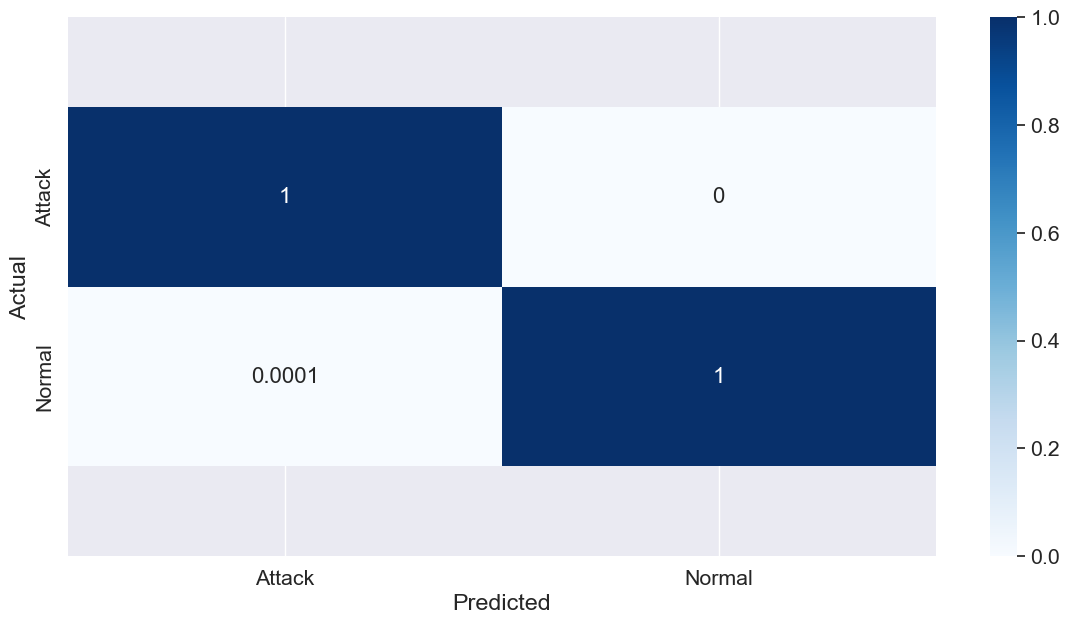

In [25]:


df_cm =  pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4)
plt.figure(figsize = (14,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

### Important features

We can see the degree of contribution of each feature to the classification result by using the __feature\_importances\___ attribute of the Random Forest Classifier. We see here that, as mentioned in the paper, the 10 features extracted from our Adaptive Clustering network consistute the 10 most important features for the classifier.

In [26]:
print("Calculating feature importance scores...")
importances = model.classifier.cls.feature_importances_
indices = np.argsort(importances)[-50:][::-1]  # -50 #most important features
cols = test_df.columns.values.tolist()

feature_importances_list = []
for f in range(len(indices)):
    feature_importances_list.append([indices[f], cols[indices[f]], importances[indices[f]]])

with open(results_path + "rf_feature_importance_scores.pkl", "wb") as f:
    pkl.dump(feature_importances_list, f)
    print(f"Feature importance scores saved: {results_path}rf_feature_importance_scores.pkl")

    print("")
    print("15 most important features")
    pprint(feature_importances_list[:15])
    print("Sum 15:", np.sum(importances[indices[:15]]))
    print("")

Calculating feature importance scores...
Feature importance scores saved: ./results/rf_feature_importance_scores.pkl

15 most important features
[[22, 'count', 0.21379174964209996],
 [5, 'dst_bytes', 0.14856229343204883],
 [2, 'service', 0.143311858803555],
 [11, 'logged_in', 0.08637403323118767],
 [36, 'dst_host_srv_diff_host_rate', 0.047148284533075055],
 [4, 'src_bytes', 0.045584212074715316],
 [31, 'dst_host_count', 0.04313930846693479],
 [1, 'protocol_type', 0.04063459498757654],
 [23, 'srv_count', 0.037373525516186355],
 [35, 'dst_host_same_src_port_rate', 0.028266921016592988],
 [28, 'same_srv_rate', 0.024513432868262946],
 [29, 'diff_srv_rate', 0.024049393774171757],
 [3, 'flag', 0.022609384568818332],
 [30, 'srv_diff_host_rate', 0.02078908025464606],
 [34, 'dst_host_diff_srv_rate', 0.01393433650265287]]
Sum 15: 0.9400824096725243



### Performance metrics

Finally, we compute the different performance metrics on our test set. We can see here again that this approach allows us to obtain a perfect score on every single evaluation metric, making this the new state-of-the-art approach for classification tasks.

In [33]:
print("Calculating performance metrics...")
cnf_matrix = confusion_matrix(y_actual_, y_hat)
_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
_tp = np.diag(cnf_matrix)
_tn = cnf_matrix.sum() - (_fp + _fn + _tp)

_fp = _fp.astype(float)
_fn = _fn.astype(float)
_tp = _tp.astype(float)
_tn = _tn.astype(float)

_fp = np.mean(_fp)
_fn = np.mean(_fn)
_tp = np.mean(_tp)
_tn = np.mean(_tn)

metrics_handler = metrics(tp=_tp, tn=_tn, fp=_fp, fn=_fn)
metrics_data = metrics_handler.get_metrics()

accuracy = accuracy_score(y_actual_, y_hat)
precision, recall, f_score, support = prf(y_actual_, y_hat, average='weighted')
print("Accuracy : {:0.7f}, Precision : {:0.7f}, Recall : {:0.7f}, F-score : {:0.7f}, FAR: {:0.7f}"
                                                      .format(accuracy, precision,
                                                              recall, f_score, metrics_data["FAR"]))

with open(results_path + "metrics_handler.pkl", "wb") as f:
    pkl.dump(metrics_handler, f)
    print(f"Performance metrics saved: {results_path}metrics_handler.pkl")




Calculating performance metrics...


NameError: name 'y_actual_' is not defined

### GRAPHES



{'epoch_0': [0.2952779636032561, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.31638661645954486, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.35395582434437395, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3643543837095311, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.35973030161382263, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3297893053214541, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

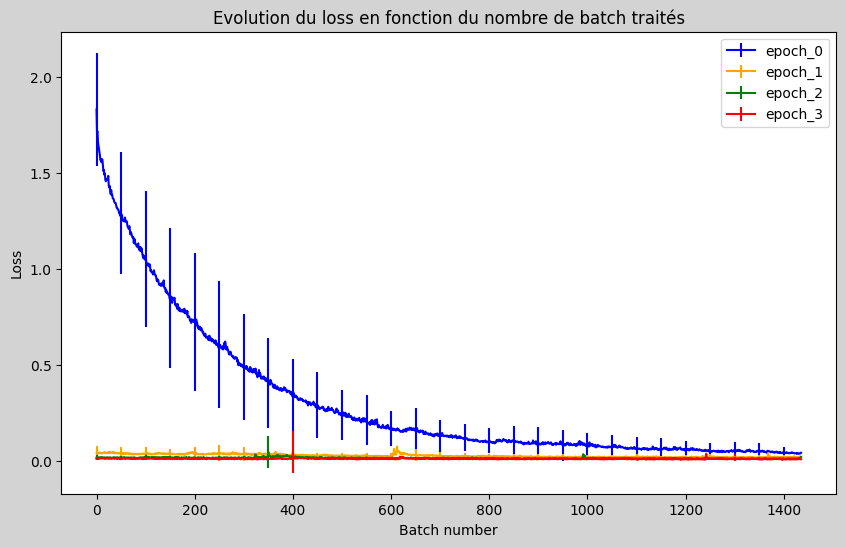

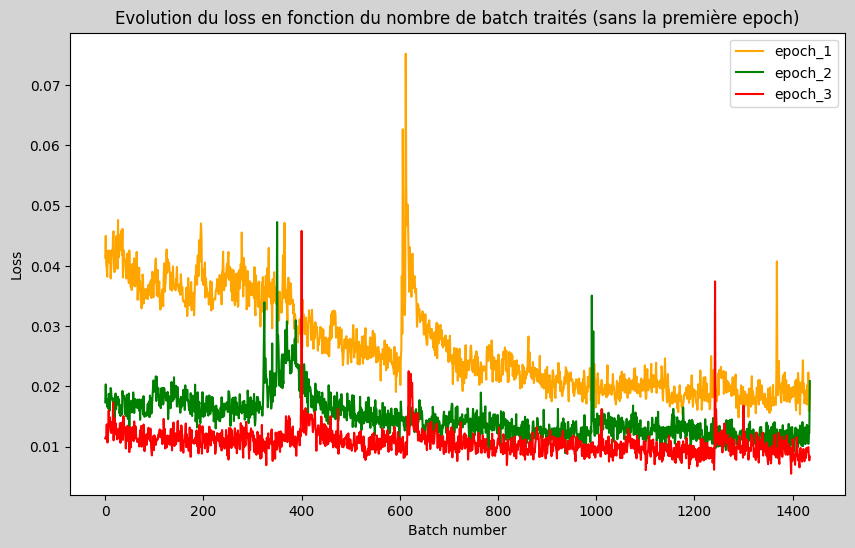

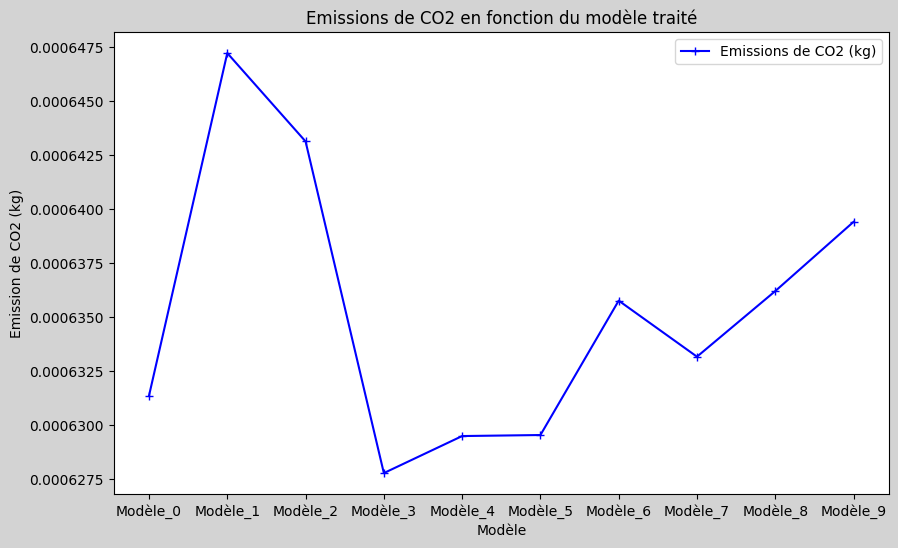

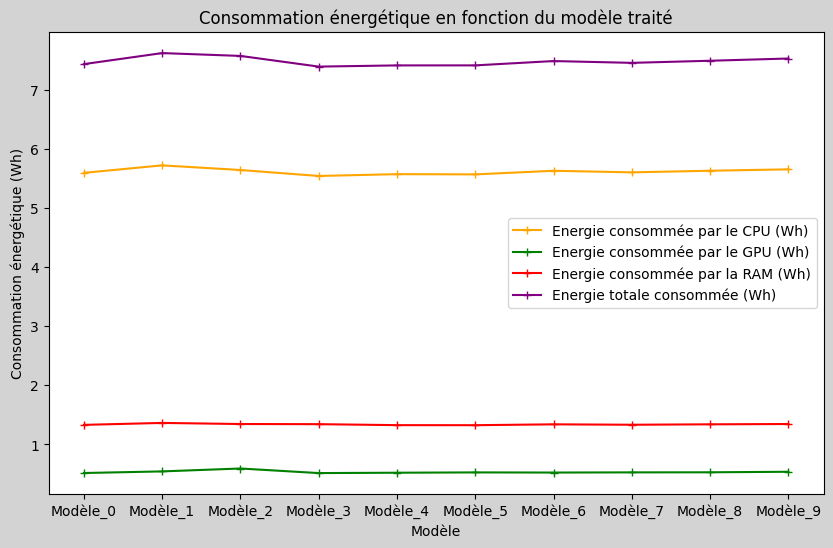

In [34]:
couleurs = ['blue','orange','green','red']

with open(results_path+"jeu_de_donnees/" +"dic_loss.pkl", 'rb') as file:
    dic_loss = pkl.load(file)
x = range(len(dic_loss["entrainement_1"]['epoch_0']))

plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

#init losses
losses = {j: [0 for i in range(len(dic_loss["entrainement_1"]["epoch_0"]))] for j in dic_loss["entrainement_1"].keys()}
std_loss = {j: [0 for i in range(len(dic_loss["entrainement_1"]["epoch_0"]))] for j in dic_loss["entrainement_1"].keys()}
# print(losses)
# print(std_loss)

#Calcul de la somme des losses pour chaque tentative et à chaque epoch
for tentative in dic_loss.keys():
    # print(tentative)
    for epoch in dic_loss[tentative].keys():
        # print(epoch)
        for v_loss in range(len(losses[epoch])):
            # print(f"loss courant: {losses[epoch][v_loss]} / somme: {dic_loss[tentative][epoch][v_loss]}")
            losses[epoch][v_loss] += dic_loss[tentative][epoch][v_loss]

#Mise à jour du dico loss en mode moyenne
losses = {j: [i/len(dic_loss.keys()) for i in losses[j]] for j in dic_loss["entrainement_1"].keys()}
# print("losses:",losses)

#Préparation des barres d'erreurs
# print("std_loss")
for _,dic_epochs in dic_loss.items():
    for e,l in dic_epochs.items():
        # print(f"e = {e}, l = {l}")
        for i in range(len(l)):
            # print(f"l[{i}] = {l[i]}, losses[{e}][{i}] = {losses[e][i]}")
            std_loss[e][i] += (l[i] - losses[e][i])**2
            # print(std_loss[e][i])

for i in std_loss.keys():
    std_loss[i] = [np.sqrt(std_loss[i][j]/len(dic_loss.keys())) if j%50==0 else 0 for j in range(len(std_loss[i]))]

c=0
for i in losses.keys():
    plt.errorbar(x, losses[i], yerr=std_loss[i], label=i, color=couleurs[c])
    c+=1
                 
#Graphe général
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Evolution du loss en fonction du nombre de batch traités')
plt.legend()
plt.savefig(results_path + './courbes/loss_evolution_with_uncertainty.png')  # Sauvegarder la figure

#Graphe précis (à partir de la 2ème epoch)
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
print(std_loss)
c=0
for i in losses.keys():
    if i != "epoch_0":
        plt.plot(x, losses[i], label=i,color=couleurs[c])
    c+=1

plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Evolution du loss en fonction du nombre de batch traités (sans la première epoch)')
plt.legend()
plt.savefig(results_path + './courbes/loss_evolution_epoch2.png')


with open(results_path+"jeu_de_donnees/"+"moyenne_loss.pkl", 'wb') as file:
        pkl.dump(losses, file)
with open(results_path+"jeu_de_donnees/"+"std_loss.pkl", 'wb') as file:
        pkl.dump(std_loss, file)


#Partie émissions
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
liste_x = []
liste_emissions_y = []
liste_cpu_energy_y = []
liste_gpu_energy_y = []
liste_ram_energy_y = []
liste_total_energy_y = []

with open("emissions.csv", "r") as csvfile:
    lecteur = csv.DictReader(csvfile, delimiter=';')
    for ligne in lecteur:
        print(ligne)
        if ligne['project_name'] != "initialisation":
            liste_emissions_y.append(float(ligne["emissions (Co2 eq in kg)"]))
            liste_cpu_energy_y.append(float(ligne["cpu_energy (kWh)"])*1000)
            liste_gpu_energy_y.append(float(ligne["gpu_energy (kWh)"])*1000)
            liste_ram_energy_y.append(float(ligne["ram_energy (kWh)"])*1000)
            liste_total_energy_y.append(float(ligne["energy_consumed (kWh)"])*1000)
            liste_x.append(ligne['project_name'])



plt.plot(liste_x,liste_emissions_y,label="Emissions de CO2 (kg)",color="blue",marker='+')
plt.xlabel('Modèle')
plt.ylabel('Emission de CO2 (kg)')
plt.title('Emissions de CO2 en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/emission_Co2.png')

#partie consommation
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

plt.plot(liste_x,liste_cpu_energy_y,label="Energie consommée par le CPU (Wh)",color="orange",marker='+')
plt.plot(liste_x,liste_gpu_energy_y,label="Energie consommée par le GPU (Wh)",color="green",marker='+')
plt.plot(liste_x,liste_ram_energy_y,label="Energie consommée par la RAM (Wh)",color="red",marker='+')
plt.plot(liste_x,liste_total_energy_y,label="Energie totale consommée (Wh)",color="purple",marker='+')

plt.xlabel('Modèle')
plt.ylabel('Consommation énergétique (Wh)')
plt.title('Consommation énergétique en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/conso_electrique.png')

plt.show()

#Conservation des données
dico_enviro = {}
dico_enviro["emissions"] = liste_emissions_y
dico_enviro["cpu_energy"] = liste_cpu_energy_y
dico_enviro["gpu_energy"] = liste_gpu_energy_y
dico_enviro["ram_energy"] = liste_ram_energy_y
dico_enviro["total_energy"] = liste_total_energy_y
dico_enviro["liste_x"] = liste_x

with open(results_path+"jeu_de_donnees/"+"dico_enviro.pkl", 'wb') as file:
        pkl.dump(dico_enviro, file)